# Clustering Unlabeled Sound Data

## Overview

In this notebook, we extract features from unlabeled audio data, apply dimensionality reduction, and perform clustering using K-Means and DBSCAN. We evaluate and compare these methods using visual and metric-based interpretations.


In [8]:
# Connect Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Make all necessary imports
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from google.colab import drive


#Load Data and Extract Features (Mel Spectrograms)

In [11]:

# Load the Data
unlabelled_data_path = ('/content/drive/My Drive/unlabelled_sounds')

def load_audio_files(folder, sr=22050):
    audio_features = []
    filenames = []
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            path = os.path.join(folder, file)
            y, _ = librosa.load(path, sr=sr)
            mel = librosa.feature.melspectrogram(y=y, sr=sr)
            mel_db = librosa.power_to_db(mel)
            feature_vector = mel_db.mean(axis=1)  # mean across time
            audio_features.append(feature_vector)
            filenames.append(file)
    return np.array(audio_features), filenames

features, filenames = load_audio_files(unlabelled_data_path)
print("Extracted features shape:", features.shape)

Extracted features shape: (3000, 128)


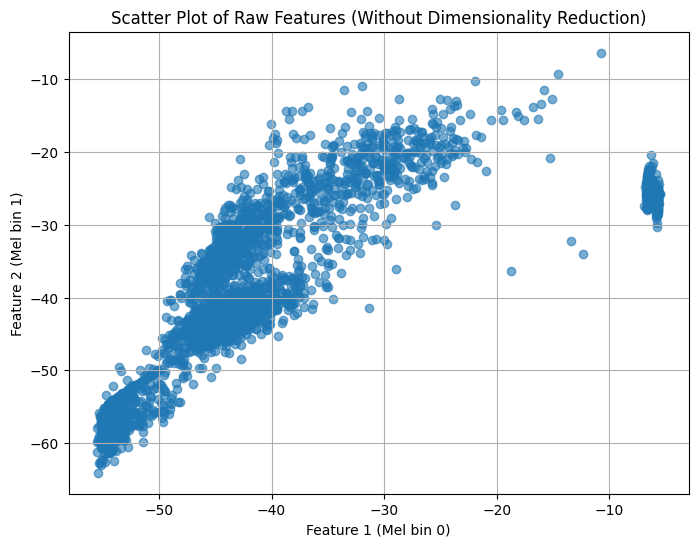

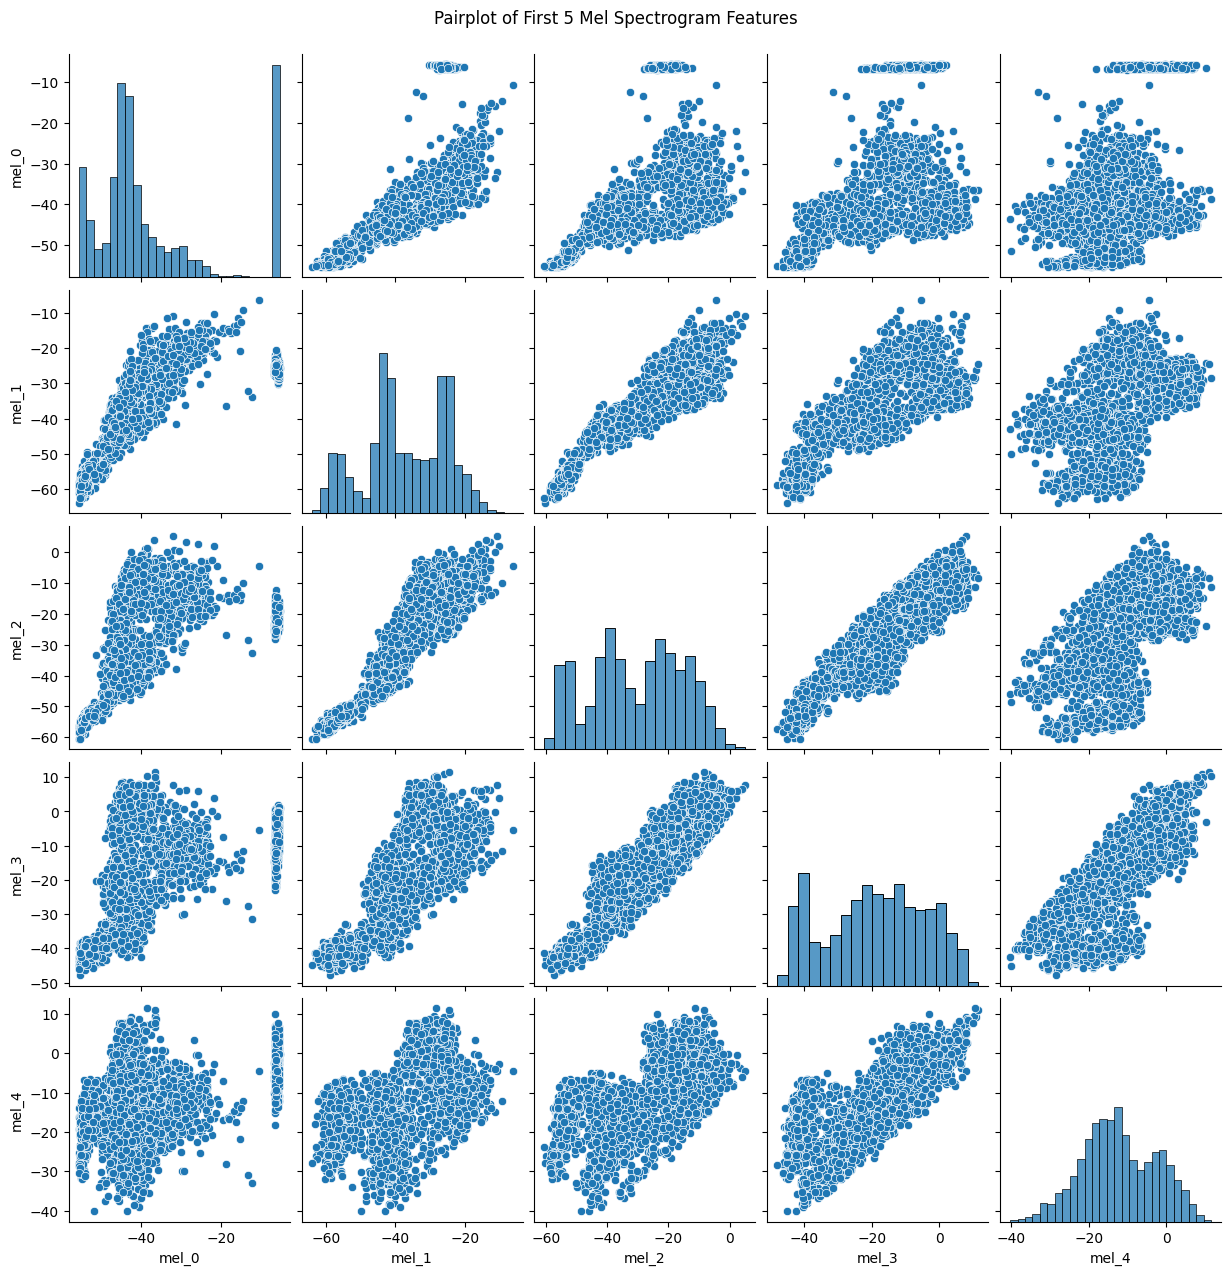

In [12]:
# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(features[:, 0], features[:, 1], alpha=0.6)
plt.xlabel("Feature 1 (Mel bin 0)")
plt.ylabel("Feature 2 (Mel bin 1)")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.grid()
plt.show()

# Pair plot (Only using first 5 features)
df = pd.DataFrame(features[:, :5], columns=[f"mel_{i}" for i in range(5)])
sns.pairplot(df)
plt.suptitle("Pairplot of First 5 Mel Spectrogram Features", y=1.02)
plt.show()


### Why is dimensionality reduction important?

### Why is Dimensionality Reduction Important?

1. In the previous scatter and pair plots using raw Mel features, we observed significant overlap and no clear separation between samples.
The raw feature space is **128-dimensional**, and visualizing just two or five features does not capture the actual structure of the data.

2. This challenge is a result of the **curse of dimensionality**, where high-dimensional data becomes sparse, noisy, and hard to interpret. Distances between points become less meaningful, and clusters—if they exist—are hidden across many dimensions.

3. To overcome this, we use **dimensionality reduction** (PCA and t-SNE) to project the data into a 3D space that preserves as much variance or local structure as possible.

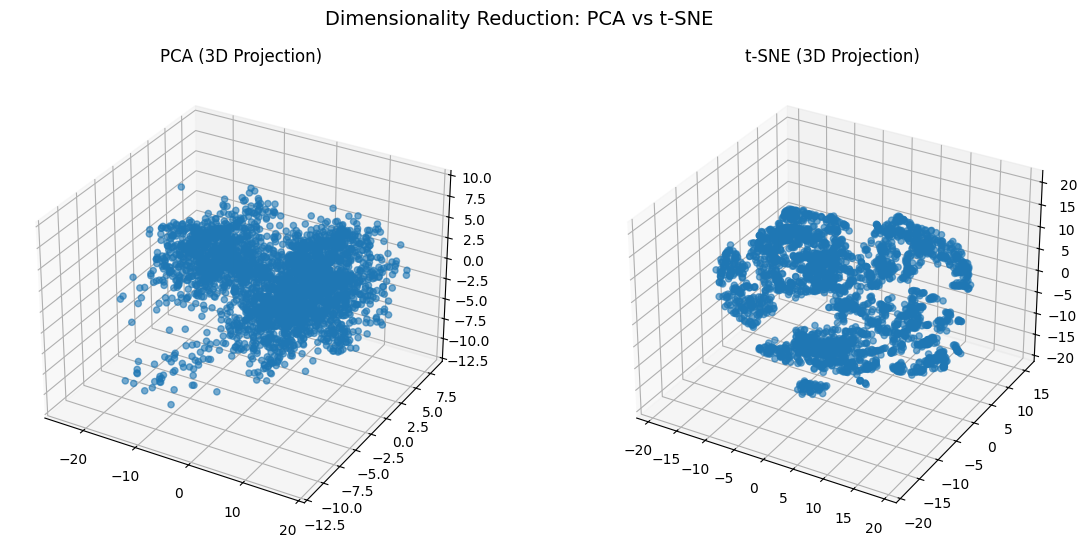

In [13]:
from mpl_toolkits.mplot3d import Axes3D

# Standardize data before applying PCA/t-SNE
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_scaled)

# Apply t-SNE
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features_scaled)

# 3D Visualization
fig = plt.figure(figsize=(14, 6))

# PCA
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], alpha=0.6)
ax1.set_title("PCA (3D Projection)")

# t-SNE
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], alpha=0.6)
ax2.set_title("t-SNE (3D Projection)")

plt.suptitle("Dimensionality Reduction: PCA vs t-SNE", fontsize=14)
plt.show()


### Which method (PCA or t-SNE) provides better separability of clusters and why?

* From the 3D visualizations, we can observe that **t-SNE** offers better visual separation between clusters compared to PCA.

* While PCA retains global variance, it assumes linear relationships and may spread overlapping clusters across axes. In contrast, t-SNE is a nonlinear method that better preserves local neighborhood structure, revealing tighter groupings that may correspond to latent clusters.

* Therefore, based on the scatter plots, **t-SNE provides better cluster separability** in this dataset.

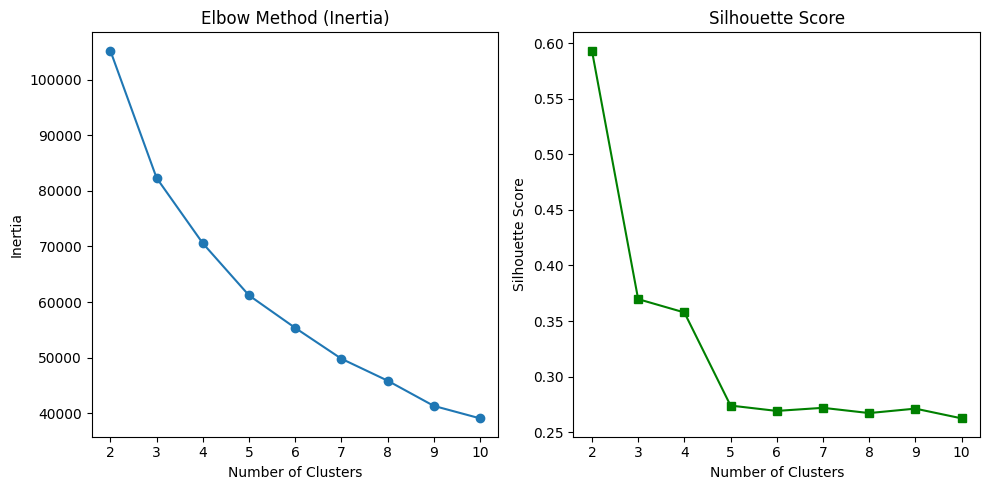

In [14]:

# Optimize number of clusters using Elbow Method
# Elbow Method and Silhouette Scores on PCA-reduced data

inertias = []
silhouettes = []

k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features_pca)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(features_pca, labels))

# Plot Elbow Curve and Silhouette Score
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouettes, marker='s', color='green')
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()



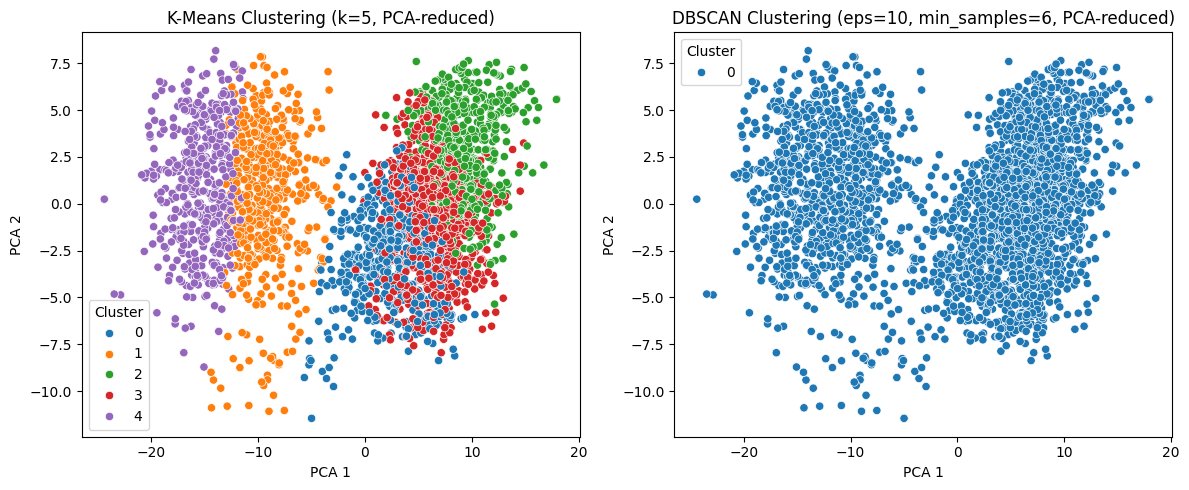

In [17]:

# Select optimal K based on elbow method (e.g., k=3)

# Set k=5 based on elbow/silhouette analysis
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_pca)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_pca)

# Plot KMeans and DBSCAN clusters (using PCA-reduced data)
plt.figure(figsize=(12, 5))

# K-Means Plot
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=features_pca[:, 0], y=features_pca[:, 1],
    hue=kmeans_labels, palette="tab10", legend="full"
)
plt.title("K-Means Clustering (k=5, PCA-reduced)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")

# DBSCAN Plot
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=features_pca[:, 0], y=features_pca[:, 1],
    hue=dbscan_labels, palette="tab10", legend="full"
)
plt.title("DBSCAN Clustering (eps=10, min_samples=6, PCA-reduced)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")

plt.tight_layout()
plt.show()



In [20]:

# Evaluate clustering eps=10, min_samples=6 for DBSCAN)

kmeans_silhouette = silhouette_score(features_pca, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_pca, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_pca, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_pca, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")


K-Means - Silhouette Score: 0.2740, Davies-Bouldin Index: 1.2662
DBSCAN failed to form meaningful clusters.


### Discussion: K-Means vs DBSCAN

K-Means produced moderately compact clusters with a Silhouette Score of 0.2740 and a Davies-Bouldin Index of 1.2662, showing average but acceptable performance.  
In contrast, DBSCAN failed to form valid clusters, assigning most or all points as noise due to unsuitable density parameters or lack of structure.  
K-Means was more robust in this scenario, benefiting from the clear separation imposed by PCA.  
DBSCAN may work better with well-separated or non-globular clusters, but its sensitivity to `eps` and `min_samples` makes it harder to tune.  
Overall, K-Means was the more effective method for this dataset.


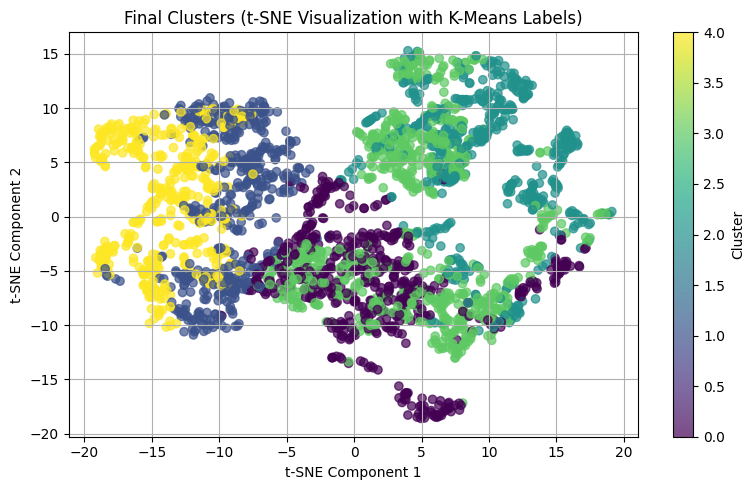

In [23]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


### Final Analysis

- Dimensionality reduction using PCA and t-SNE was essential for uncovering structure in the high-dimensional Mel spectrogram data. Without it, features were too entangled and noisy for effective clustering or visualization.

- K-Means clustering worked better than DBSCAN because it performs well with globular cluster assumptions and is less sensitive to parameter tuning. DBSCAN struggled with density estimation, especially in compressed PCA space.

- This aligns with real-world clustering challenges, where high-dimensional audio, image, or text data often require transformation before patterns emerge. Proper preprocessing, dimensionality reduction, and algorithm choice were key to successful analysis.
